In [21]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import category_encoders as ce

In [23]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()

# Reducing dimensionality of TimeZones 
def binary_encode_timezone(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

# Data Loading and Preprocessing

In [3]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# Reducing dimensionality of Carrier with custom grouping
value_counts = flights_df['Carrier'].value_counts()
to_remove = value_counts[value_counts <= 9000].index
flights_df['Carrier'].replace(to_remove, 'Other', inplace=True)

#  4) Calculate Employees Per Monthly Flight Count (Grand Total / Monthly Flights)
## Group flight dataset by Tail_Number
flightCount_df = pd.DataFrame(flights_df.groupby(['Carrier', 'Year', 'Month'])['Carrier'].count())
flightCount_df.rename(columns={'Carrier': 'MonthlyFlights'}, inplace=True)
flightCount_df = flightCount_df.reset_index()

## Merge Monthly flight count and calculate EmpPerMF
flights_df = pd.merge(flights_df, flightCount_df, how='left', left_on=['Carrier', 'Year', 'Month'], right_on=['Carrier', 'Year', 'Month'])
flights_df['EmpPerMF'] = flights_df['Grand Total'] / flights_df['MonthlyFlights']

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,...,Dest_Windspeed,Dest_Precip,dest_ianaTimeZone,origin_ianaTimeZone,Aircraft_Daily_Flight_Count,FlightDateDT,DepTarmacTime,ArrTarmacTime,MonthlyFlights,EmpPerMF
0,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N407AN,664.0,KOA,...,0.0,0.0,America/Phoenix,America/Los_Angeles,1,2020-01-01,900.0,360.0,1245,86.306827
1,2020.0,1.0,1.0,1.0,3.0,2020-01-01,9E,N297PQ,5270.0,LFT,...,5.0,0.0,America/New_York,America/Chicago,1,2020-01-01,900.0,420.0,337,14.373887
2,2020.0,1.0,1.0,1.0,3.0,2020-01-01,WN,N963WN,1395.0,CMH,...,7.0,0.0,America/Chicago,America/New_York,1,2020-01-01,540.0,300.0,1542,40.347601
3,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N891NN,137.0,TUS,...,8.0,0.0,America/Chicago,America/Phoenix,1,2020-01-01,1200.0,840.0,1245,86.306827
4,2020.0,1.0,1.0,1.0,3.0,2020-01-01,AA,N807AW,2189.0,SAT,...,12.0,0.0,America/Chicago,America/Chicago,1,2020-01-01,660.0,960.0,1245,86.306827


# Initial Model Run

In [19]:
# Columns to use as Features
features = ['DepDelay', 'Month', 'DayOfWeek', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip', 'Aircraft_Daily_Flight_Count']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=500, learning_rate=0.12, random_state=42)
gb_model.fit(x_train,y_train)

# Predict model output
gb_predict = gb_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, gb_predict)
f1 = f1_score(y_test, gb_predict)

#print AUC score
print('(AUC) XGBoost: %.4f' % auc)
print('F1 Score: %.4f' % f1)

# DepDelay = .8598
# DepDelay 'Month', 'DayOfWeek', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip', 'Aircraft_Daily_Flight_Count'] = .924

(AUC) XGBoost: 0.9249
F1 Score: 0.9240


# Model Run with Classifiers

In [24]:
# Columns to use as Features
features = ['DepDelay', 'Month', 'DayOfWeek', 'AirTime', 'Distance', 'DepTarmacTime', 'Origin_Windspeed','Dest_Windspeed', 'Origin_Precip', 'Dest_Precip', 'Aircraft_Daily_Flight_Count', 'origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin', 'Carrier']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343120 entries, 0 to 343119
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   DepDelay                     343120 non-null  float64
 1   Month                        343120 non-null  float64
 2   DayOfWeek                    343120 non-null  float64
 3   AirTime                      343120 non-null  float64
 4   Distance                     343120 non-null  float64
 5   DepTarmacTime                343120 non-null  float64
 6   Origin_Windspeed             343120 non-null  float64
 7   Dest_Windspeed               343120 non-null  float64
 8   Origin_Precip                343120 non-null  float64
 9   Dest_Precip                  343120 non-null  float64
 10  Aircraft_Daily_Flight_Count  343120 non-null  int64  
 11  origin_ianaTimeZone_0        343120 non-null  int64  
 12  origin_ianaTimeZone_1        343120 non-null  int64  
 13 

In [30]:
# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier( random_state=42)
gb_model.fit(x_train,y_train)

# Predict model output
gb_predict = gb_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, gb_predict)
f1 = f1_score(y_test, gb_predict)

#print AUC score
print('(AUC) XGBoost: %.4f' % auc)
print('F1 Score: %.4f' % f1)

(AUC) XGBoost: 0.9342
F1 Score: 0.9335


# Parameter Tuning

In [33]:
# Tune Nodes and Learning Rate to find best combination
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]


param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

In [27]:
# Fine tune Learning Rate and Nodes for best combination
n_estimators = [500, 600, 700, 800, 900, 1000]
learning_rate = [0.1, 0.15]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')


Best: -0.165267 using {'learning_rate': 0.1, 'n_estimators': 700}
-0.168741 (0.002544) with: {'learning_rate': 0.1, 'n_estimators': 400}
-0.166994 (0.002554) with: {'learning_rate': 0.1, 'n_estimators': 500}
-0.165924 (0.002491) with: {'learning_rate': 0.1, 'n_estimators': 600}
-0.165267 (0.002492) with: {'learning_rate': 0.1, 'n_estimators': 700}
-0.166378 (0.002686) with: {'learning_rate': 0.15, 'n_estimators': 400}
-0.165767 (0.002632) with: {'learning_rate': 0.15, 'n_estimators': 500}
-0.165713 (0.002743) with: {'learning_rate': 0.15, 'n_estimators': 600}
-0.165741 (0.002856) with: {'learning_rate': 0.15, 'n_estimators': 700}


NameError: name 'pyplot' is not defined

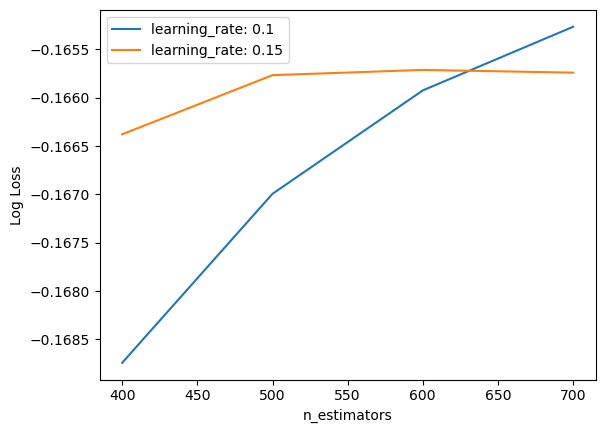

In [29]:
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

# Model Post Tuning

In [32]:
# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1, random_state=42)
gb_model.fit(x_train,y_train)

# Predict model output
gb_predict = gb_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, gb_predict)
f1 = f1_score(y_test, gb_predict)

#print AUC score
print('(AUC) XGBoost: %.4f' % auc)
print('F1 Score: %.4f' % f1)

(AUC) XGBoost: 0.9381
F1 Score: 0.9375
